In [1]:
"""
Learning growth constants model
===============================

In this example we will learn a growth constants model from a leaf that follows a
basipetal growth pattern.

"""

###############################################################################
# We first import what we need.
#

import sys
sys.path.append("../../")

import math
import pickle
import copy

import numpy as np
import torch
import matplotlib.pyplot as plt

import implicitmodules.torch as dm

###############################################################################
# We load the data, rescale it and zero it.
#
# In order to get more information, we also load the points.
#

In [2]:
data = pickle.load(open("../../data/basipetal.pkl", 'rb'))

height_source = 38.
height_target = 100.

dots_source = torch.tensor(data['source_d'], dtype=torch.get_default_dtype())
dots_target = torch.tensor(data['target_d'], dtype=torch.get_default_dtype())
shape_source = torch.tensor(data['source_c'], dtype=torch.get_default_dtype())
shape_target = torch.tensor(data['target_c'], dtype=torch.get_default_dtype())

smin, smax = torch.min(shape_source[:, 1]), torch.max(shape_source[:, 1])
sscale = height_source / (smax - smin)
dots_source[:, 1] = - sscale * (dots_source[:, 1] - smax)
dots_source[:, 0] = sscale * (dots_source[:, 0] - torch.mean(shape_source[:, 0]))
shape_source[:, 1] = - sscale * (shape_source[:, 1] - smax)
shape_source[:, 0] = sscale * (shape_source[:, 0] - torch.mean(shape_source[:, 0]))

tmin, tmax = torch.min(shape_target[:, 1]), torch.max(shape_target[:, 1])
tscale = height_target / (tmax - tmin)
dots_target[:, 1] = - tscale * (dots_target[:, 1] - tmax)
dots_target[:, 0] = tscale * (dots_target[:, 0] - torch.mean(shape_target[:, 0]))
shape_target[:, 1] = - tscale * (shape_target[:, 1] - tmax)
shape_target[:, 0] = tscale * (shape_target[:, 0] - torch.mean(shape_target[:, 0]))

# We only have dot data for one side of the leaf
shape_source = shape_source[shape_source[:, 0] <= 0]
shape_target = shape_target[shape_target[:, 0] <= 0]

In [3]:
###############################################################################
# We now sample the points that will be used by the deformation modules.
#

# Build AABB around the source shape and uniformly sample points for the implicit
# module of order 1
aabb_source = dm.Utilities.AABB.build_from_points(shape_source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 0.25, shape=shape_source)

rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)

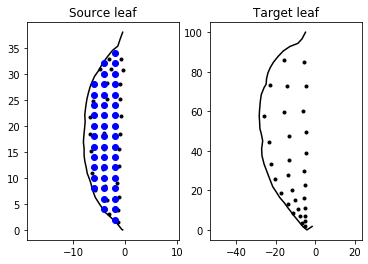

In [4]:
###############################################################################
# Plot everything.
#

plt.subplot(1, 2, 1)
plt.title("Source leaf")
plt.plot(dots_source[:, 0].numpy(), dots_source[:, 1].numpy(), '.', color='black')
plt.plot(shape_source[:, 0].numpy(), shape_source[:, 1].numpy(), color='black')
plt.plot(points_growth[:, 0].numpy(), points_growth[:, 1].numpy(), 'o', color='blue')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.title("Target leaf")
plt.plot(shape_target[:, 0].numpy(), shape_target[:, 1].numpy(), color='black')
plt.plot(dots_target[:, 0].numpy(), dots_target[:, 1].numpy(), '.', color='black')
plt.axis('equal')

plt.show()

In [5]:
###############################################################################
# We now build the implicit module that will model the growth.
#
# Since we will be learning its growth constants, we need to set its
# `requires_grad` flag to `True`.
#

nu = 0.001
coeff_growth = 1.
scale_growth = 25.

global_translation = dm.DeformationModules.GlobalTranslation(2)

C = torch.ones(points_growth.shape[0], 2, 1)

growth = dm.DeformationModules.ImplicitModule1(
    2, points_growth.shape[0], scale_growth, C, coeff=coeff_growth, nu=nu,
    gd=(points_growth.clone().requires_grad_(),
        rot_growth.clone().requires_grad_()))

In [6]:
###############################################################################
# Quadratic model for the growing constants.
#

# Initial parameters of our model
abc = torch.zeros(6, 2)
abc[0] = torch.ones(2)
abc.requires_grad_()

# The polynomial model we will try to fit on our deformation constants
def pol_order_2(pos, a, b, c, d, e, f):
    return a + b*pos[:, 0] + c*pos[:, 1] + d*pos[:, 0]**2 + e*pos[:, 1]**2 + f*pos[:, 0]*pos[:, 1]

# Callback called when evaluating the model.
# Serves as glue for our model of deformation constants.
def callback_compute_c(init_manifold, modules, parameters):
    abc = parameters['abc']['params'][0]
    a = abc[0].unsqueeze(1)
    b = abc[1].unsqueeze(1)
    c = abc[2].unsqueeze(1)
    d = abc[3].unsqueeze(1)
    e = abc[4].unsqueeze(1)
    f = abc[5].unsqueeze(1)
    modules[3]._ImplicitModule1Base__C = pol_order_2(
        init_manifold[3].gd[0], a, b, c, d, e, f).transpose(0, 1).unsqueeze(2)


In [10]:
deformable_shape_source = dm.Models.DeformablePoints(shape_source)
deformable_shape_target = dm.Models.DeformablePoints(shape_target)
deformable_dots_source = dm.Models.DeformablePoints(dots_source)
deformable_dots_target = dm.Models.DeformablePoints(dots_target)


In [11]:
###############################################################################
# We now define the model. We set the model parameters as an other parameter
# so that it also get learned.
#

model = dm.Models.RegistrationModel([deformable_shape_source, deformable_dots_source], [global_translation, growth], [dm.Attachment.VarifoldAttachment(2, [5., 25, 80.]), dm.Attachment.EuclideanPointwiseDistanceAttachment(50.)], lam=100., other_parameters={'abc': {'params': [abc]}}, precompute_callback=callback_compute_c)

In [12]:
###############################################################################
# Fitting.
#

shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = dm.Models.Fitter(model, optimizer='torch_lbfgs')
fitter.fit([deformable_shape_target, deformable_dots_target], 500, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})


Starting optimization with method torch LBFGS
Initial cost={'deformation': tensor(0.), 'attach': tensor(7342079.5000)}
Time: 32.33587515899853
Iteration: 0
Costs
deformation=24.1639404296875
attach=5824583.5
Total cost=5824607.66394043
Time: 66.02242566499626
Iteration: 1
Costs
deformation=26.057186126708984
attach=5761745.5
Total cost=5761771.557186127
Time: 99.54343005199917
Iteration: 2
Costs
deformation=31.328594207763672
attach=5623719.0
Total cost=5623750.328594208
Time: 129.7662230709975
Iteration: 3
Costs
deformation=37.483177185058594
attach=5556098.5
Total cost=5556135.983177185
Time: 164.9554219329948
Iteration: 4
Costs
deformation=162.5858917236328
attach=4527046.0
Total cost=4527208.585891724
Time: 195.73396038999635
Iteration: 5
Costs
deformation=13290.9931640625
attach=737109.25
Total cost=750400.2431640625
Time: 225.7588554939939
Iteration: 6
Costs
deformation=23505.15234375
attach=522839.59375
Total cost=546344.74609375
Time: 261.7832954619953
Iteration: 7
Costs
deform

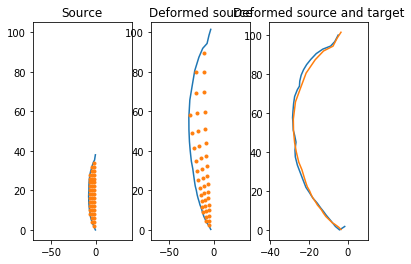

In [16]:


###############################################################################
# Plot matching results.
#

intermediates = {}
model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)

intermediate_states = intermediates['states']
deformed_source = intermediate_states[-1][0].gd
deformed_growth = intermediate_states[-1][3].gd[0]
deformed_growth_rot = intermediate_states[-1][3].gd[1]

aabb_target = dm.Utilities.AABB.build_from_points(shape_target).squared().scale(1.1)

plt.subplot(1, 3, 1)
plt.title("Source")
plt.plot(shape_source[:, 0].numpy(), shape_source[:, 1].numpy(), '-')
plt.plot(points_growth[:, 0].numpy(), points_growth[:, 1].numpy(), '.')
plt.axis(aabb_target.totuple())

plt.subplot(1, 3, 2)
plt.title("Deformed source")
plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-')
plt.plot(deformed_growth[:, 0], deformed_growth[:, 1], '.')
plt.axis(aabb_target.totuple())

plt.subplot(1, 3, 3)
plt.title("Deformed source and target")
plt.plot(shape_target[:, 0].numpy(), shape_target[:, 1].numpy(), '-')
plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-')
plt.axis(aabb_target.totuple())


plt.axis('equal')
plt.show()



Learned growth constants model parameters:
tensor([[ -8.0059,  34.7353],
        [ 19.0192, -53.8247],
        [ 17.1627,  -7.5977],
        [  7.3806, -12.2291],
        [  0.0874,   0.4112],
        [  2.4811,  -2.3286]])


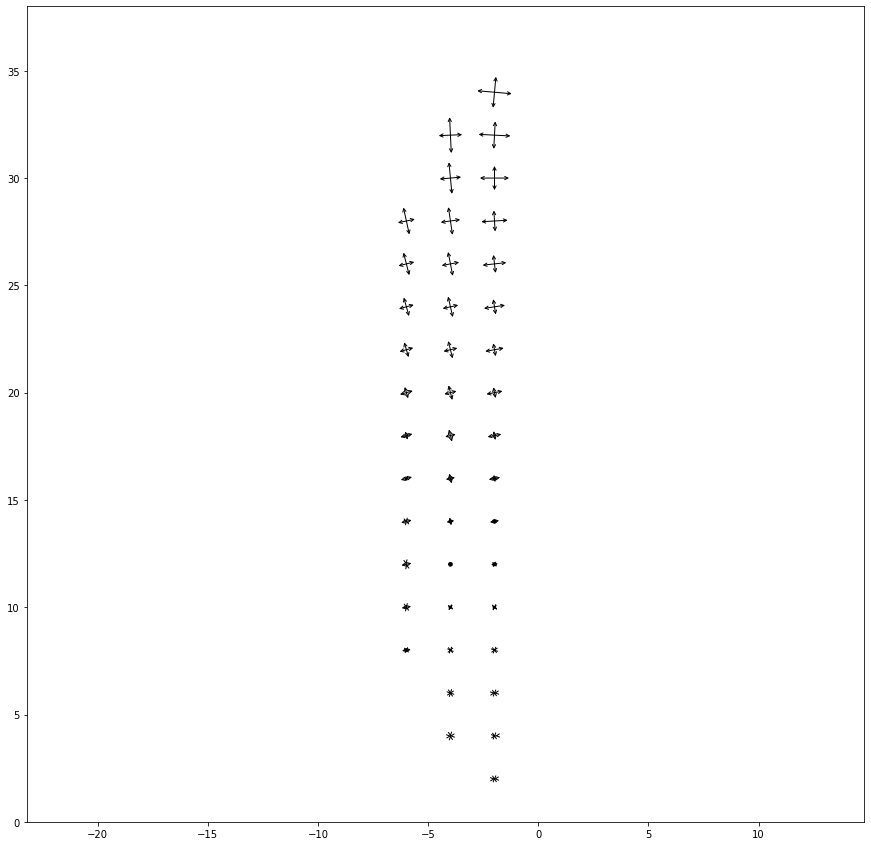

In [15]:

###############################################################################
# Evaluate and plot learned growth constants. We see more growth at the basis
# than at the apex: this is basipetal growth.
#

learned_abc = abc.detach()
learned_C = pol_order_2(model.init_manifold[3].gd[0].detach(),
                        learned_abc[0].unsqueeze(1),
                        learned_abc[1].unsqueeze(1),
                        learned_abc[2].unsqueeze(1),
                        learned_abc[3].unsqueeze(1),
                        learned_abc[4].unsqueeze(1),
                        learned_abc[5].unsqueeze(1)).transpose(0, 1).unsqueeze(2)

print("Learned growth constants model parameters:")
print(learned_abc)

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(1,1,1)
dm.Utilities.plot_C_arrows(ax, points_growth, learned_C, R=deformed_growth_rot, scale=0.0035, mutation_scale=8.)
plt.axis(aabb_source.squared().totuple())
plt.show()



In [17]:

###############################################################################
# Now we use the learnt model to fit the whole leaf shape
#

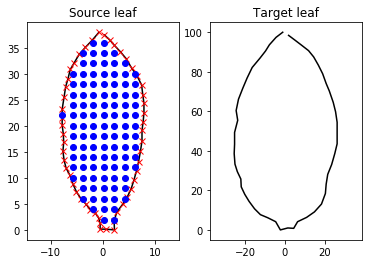

In [18]:

data_source = pickle.load(open("../../data/leafbasi.pkl", 'rb'))
data_target = pickle.load(open("../../data/leafbasit.pkl", 'rb'))

height_source = 38.
height_target = 100.

source = torch.tensor(data_source[1]).type(torch.get_default_dtype())
target = torch.tensor(data_target[1]).type(torch.get_default_dtype())

smin, smax = torch.min(source[:, 1]), torch.max(source[:, 1])
sscale = height_source / (smax - smin)
source[:, 1] = - sscale * (source[:, 1] - smax)
source[:, 0] = sscale * (source[:, 0] - torch.mean(source[:, 0]))

tmin, tmax = torch.min(target[:, 1]), torch.max(target[:, 1])
tscale = height_target / (tmax - tmin)
target[:, 1] = - tscale * (target[:, 1] - tmax)
target[:, 0] = tscale * (target[:, 0] - torch.mean(target[:, 0]))

# Extract shape informations from the dataset
shape_source = source[source[:, 2] == 2, 0:2]
shape_target = target[target[:, 2] == 2, 0:2]

###############################################################################
# We now sample the points that will be used by the deformation modules.
#

# Points for our contour
points_small = shape_source.clone()

# Build AABB around the source shape and uniformly sample points for the implicit
# module of order 1
aabb_source = dm.Utilities.AABB.build_from_points(shape_source)
points_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_source, 0.25, shape=shape_source)

rot_growth = torch.stack([dm.Utilities.rot2d(0.)]*points_growth.shape[0], axis=0)

###############################################################################
# Plot everything.
#

plt.subplot(1, 2, 1)
plt.title("Source leaf")
plt.plot(shape_source[:, 0].numpy(), shape_source[:, 1].numpy(), color='black')
plt.plot(points_small[:, 0].numpy(), points_small[:, 1].numpy(), 'x', color='red')
plt.plot(points_growth[:, 0].numpy(), points_growth[:, 1].numpy(), 'o', color='blue')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.title("Target leaf")
plt.plot(shape_target[:, 0].numpy(), shape_target[:, 1].numpy(), color='black')
plt.axis('equal')

plt.show()
